# Plot percent IFN positive cells

First, load packages and define functions:

In [1]:
# install R packages
r_packages <- c(
  "ggplot2", "cowplot", "dplyr", "magrittr", "viridis",
  "IRdisplay", "tidyverse", "stringr", "scales")
suppressMessages(invisible(
  lapply(r_packages, library, character.only=TRUE)))

# http://www.cookbook-r.com/Graphs/Colors_(ggplot2)/#a-colorblind-friendly-palette
# The palette with grey:
cbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", 
               "#0072B2", "#D55E00", "#CC79A7")

saveShowPlot <- function(p, width, height, plotname=NA) {
  if (is.na(plotname))
    plotname <- gsub("\\.", "_", deparse(substitute(p))) 
  pngfile <- sprintf("%s.png", plotname)
  pdffile <- sprintf("%s.pdf", plotname)
  ggsave(pngfile, plot=p, width=width, height=height, units="in")
  ggsave(pdffile, plot=p, width=width, height=height, units="in")
  display_png(file=pngfile, width=width * 90)
}

Next read in data on percent IFN+:

In [2]:
ifn_data <- read.csv("ifn_stats.csv") %>% 
  select(experiment, sample, replicate, IFNpercent)

Now plot these data.
We draw a dashed line at the limit of detection determined by the gating in the [analyze_flow.ipynb](analyze_flow.ipynb) notebook:

We use a one-sided t-test to compute the probability that the IFN+ exceeds wildtype, and color orange those samples where P < 0.01 for this test.
We perform this test on the **log** of the values since that is the scale on which we plot.

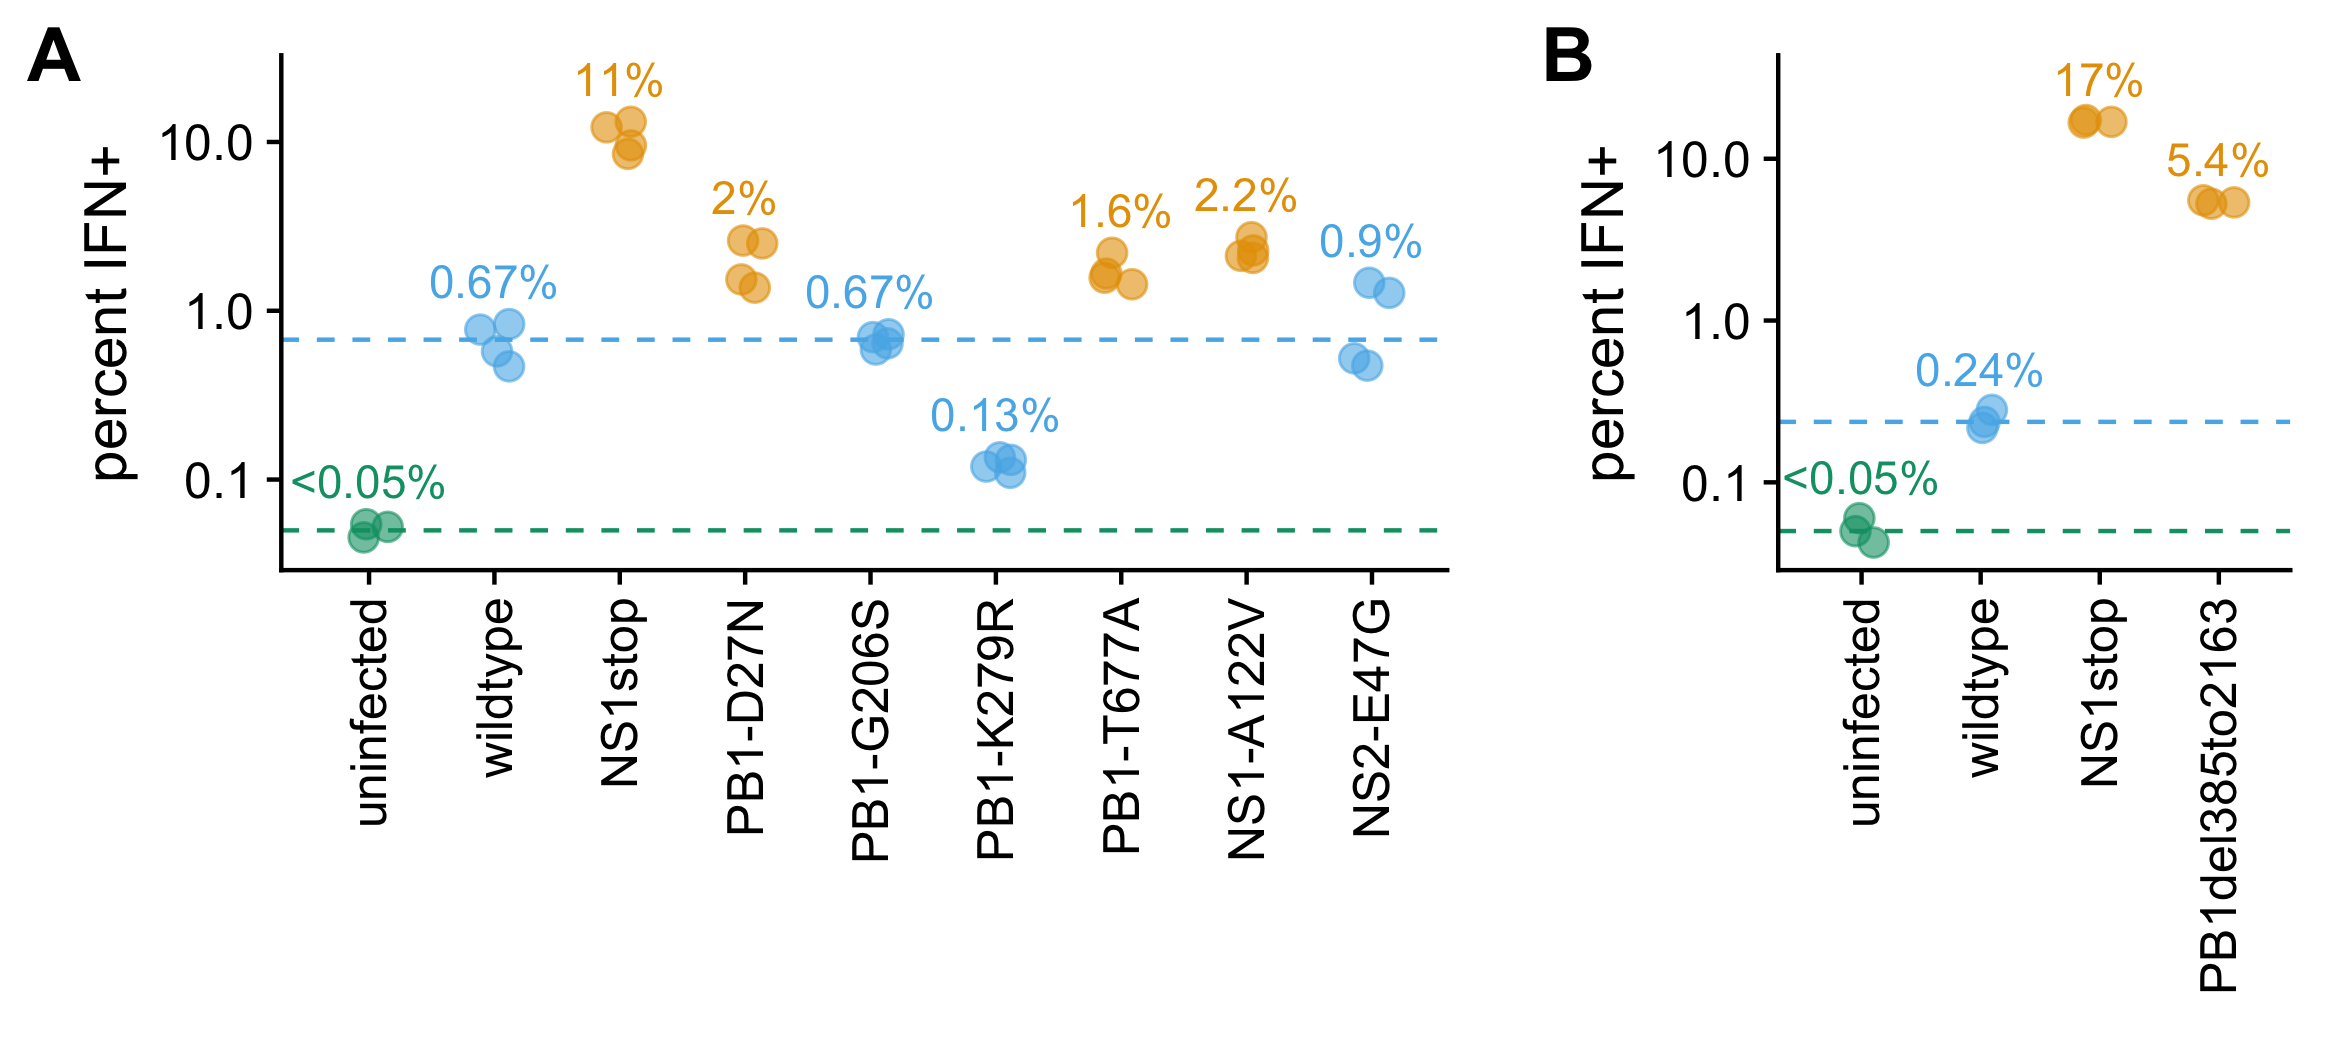

In [3]:
detect_limit <- 0.05

set.seed(9) # seed that gives nice jittering

plot_ifn_percent <- function(experiment, experiment_data) {
  samples <- experiment_data$sample %>% unique
    
  experiment_data <- experiment_data %>%
    mutate(color=ifelse(sample == "uninfected", "uninfected",
                 ifelse(P < 0.01, "significant", "not significant")))
     
  ggplot(
      experiment_data %>% transform(sample=factor(sample, samples)),
      aes(sample, IFNpercent, color=color)) +
    geom_jitter(height=0, width=0.15, size=3, alpha=0.6) +
    geom_text(
      data=experiment_data %>% 
        group_by(sample) %>% 
        summarize(median=median(IFNpercent),
                  max=max(IFNpercent),
                  color=first(color)) %>%
        mutate(label=ifelse(sample == "uninfected", 
                     paste0("<", round(signif(median, 2), 2), "%"),
                     paste0(round(signif(median, 2), 2), "%"))
        ),
      aes(sample, y=1.8 * max, label=label), hjust=0.5
      ) +
    scale_y_log10(name="percent IFN+") +
    scale_color_manual(values=c(cbPalette[3], cbPalette[2], cbPalette[4])) +
    theme(
      legend.position='none',
      axis.text.x=element_text(angle=90, vjust=0.5, hjust=1, size=12),
      axis.title.x=element_blank()
      ) +
    geom_hline(yintercept=detect_limit, linetype='dashed', color=cbPalette[4]) +
    geom_hline(
      yintercept=experiment_data %>% filter(sample == "wildtype") %$% IFNpercent %>% median,
      linetype='dashed', color=cbPalette[3]) +
    expand_limits(x=c(0.3, 3.8), y=c(0.04, 18))
  }

ifn_plots <- lapply(
  ifn_data$experiment %>% unique,
  function (expt) {
    experiment_data <- ifn_data %>% 
      filter(experiment == expt)
    
    samples <- experiment_data$sample %>% unique
    
    # compute one sided P-value that IFN+ greater than wildtype  
    experiment_data <- experiment_data %>%
      mutate(logIFNpercent=log10(IFNpercent)) %>%
      group_by(sample) %>%
      mutate(IFNlist=list(logIFNpercent)) %>%
      ungroup %>%
      select(sample, IFNlist) %>%
      unique %>%
      spread(sample, IFNlist) %>%
      mutate(reference=wildtype) %>%
      gather(sample, IFNlist, -reference) %>%
      group_by(sample) %>%
      mutate(P=t.test(unlist(IFNlist), unlist(reference), alternative="greater")$p.value) %>%
      select(sample, P) %>%
      merge(experiment_data) %>%
      transform(sample=factor(sample, samples)) %>%
      arrange(sample)
    
    plot_ifn_percent(expt, experiment_data)
    }
  )

ifn_plot <- plot_grid(
  plotlist=ifn_plots,
  align='h', nrow=1,
  labels=c("A", "B"), label_size=18, hjust=-0.5,
  rel_widths=c(11, 6), scale=0.95
  )

saveShowPlot(ifn_plot, height=3.5, width=7.8)

# Plot qPCR data for PB1-deletion
In the plots above for the PB1 deletion mutant, and issue was virus normalization.
It was not possible to normalize by HA staining because the PB1 deletion expresses less HA due to lack of secondary transcription.
So we have an experiment where the viruses (at the titers used in the experiment) are infected into cells at MOI of 0.4 +/- cycloheximide (which blocks translation and hence secondary transcription), and then virus levels are computed by qPCR after 8 hours.
As shown below, there is variable signal in absence of cycloheximide due to different amounts of secondary transcription.
But in the presence of cycloheximide, all express roughly similar amounts of viral mRNA.

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”

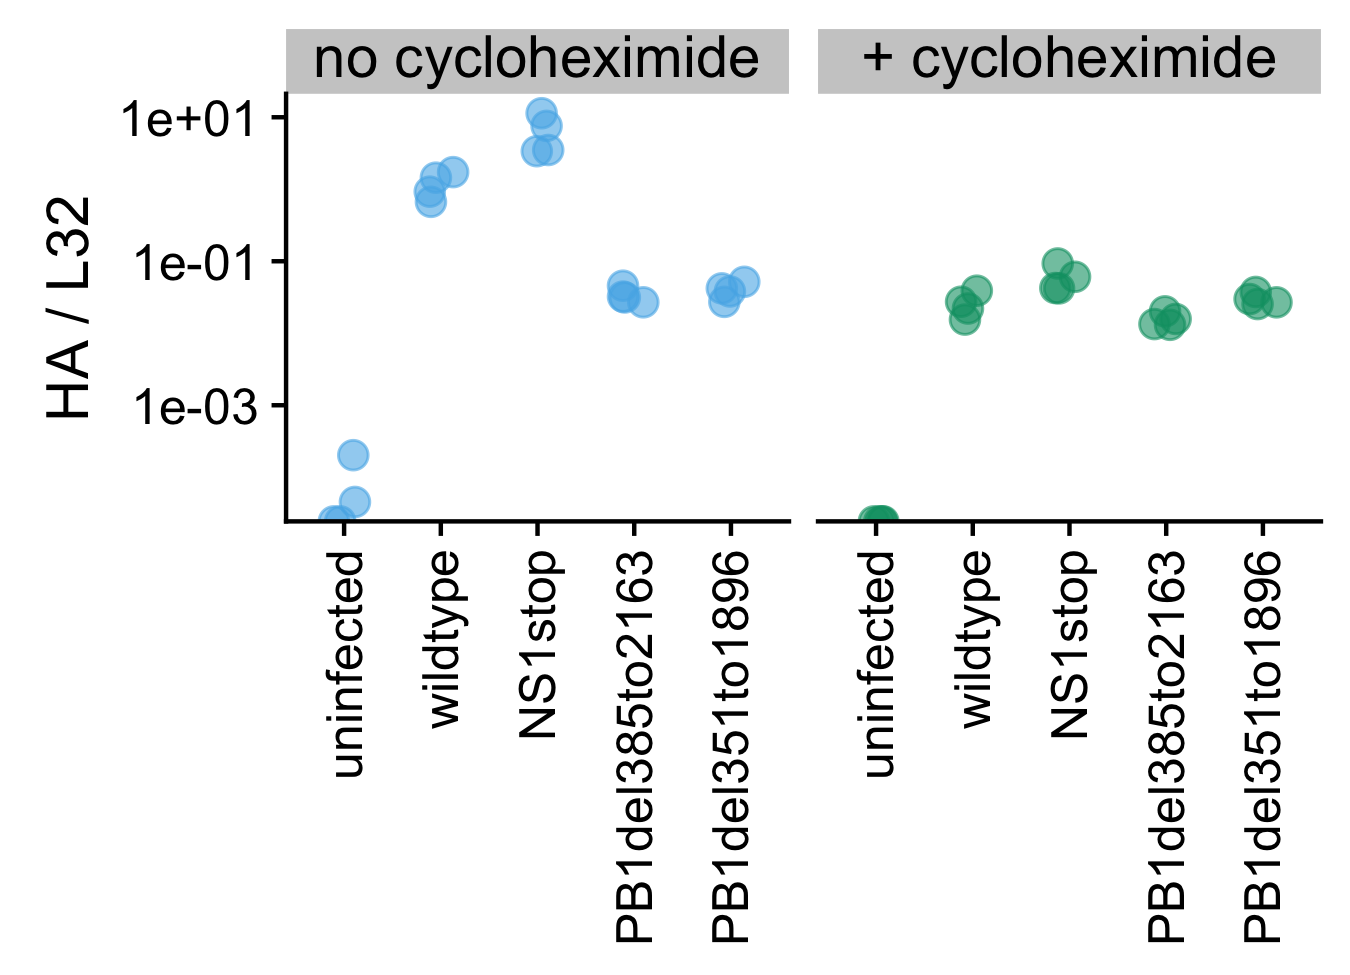

In [4]:
qpcr_data <- read.csv('qPCR/cycloheximide.csv') %>%
  mutate(
    Sample=recode(Sample,
      Pure="wildtype",
      `NS1*`="NS1stop",
      Uninfected="uninfected",
      PB1d1="PB1del385to2163",
      PB1d4="PB1del351to1896"),
    Cycloheximide=recode(Cycloheximide,
      No="no cycloheximide",
      Yes="+ cycloheximide"
      )
    ) %>%
  transform(Sample=factor(Sample,
    c("uninfected", "wildtype", "NS1stop", "PB1del385to2163", "PB1del351to1896")))
  
set.seed(1) # reproducible jittering

qpcr_plot <- ggplot(
    qpcr_data,
    aes(Sample, HA, color=Cycloheximide)) +
  geom_jitter(height=0, width=0.15, size=3, alpha=0.6) +
  scale_y_log10(name="HA / L32") +
  facet_wrap(~ Cycloheximide) +
  theme(
    legend.position='none',
    strip.text=element_text(size=14, margin=margin(b=3)),
    axis.text.x=element_text(angle=90, vjust=0.5, hjust=1, size=12),
    axis.title.x=element_blank()
    ) +
  scale_color_manual(values=cbPalette[3:4])

saveShowPlot(qpcr_plot, width=4.5, height=3.25)